For creating our Neural Network API, we will use the numpy library.
Let's also import matplotlib to plot our results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Network Layers

A typical two-layer neural network is set-up as follows:

**Input -> First Linear Layer -> Activation Function -> Second Linear Layer -> Output**

In this feed-forward architecture, the network works in two passes: forward and backward.

* *Forward pass*: It takes input from previous layer and send output to next layer.
* *Backward pass*: It takes error gradient with respect to output variable and calculates error gradient with respect to input variable. It also calculates the gradient with respect to its parameters that are to be trained.

So, the network can be divided into a set of **Layers**, each layer responsible for a forward and a backward pass.

In [3]:
class Layer:
    """
    A layer in the network can do one of the following four things:
    
    * forward pass: Accepts an input and generates an output.
    * backward pass: Accepts the gradient of a the error with respect to the output variable
                     and uses the chain rule to return the gradient with respect to the input variable.
                     This is also where the gradient with respect to the layer parameters are calculated.
    * init_params: Initialze any parameters involved in this layer.
    * update_params: Update any parameters involved in this layer as part of the training process,
                     with the learning rate alpha.
    """

    def forward(self, input_data):
        raise NotImplementedError
        
    def backpropagate(self, out_gradient):
        raise NotImplementedError
        
    def init_params(self):
        pass
        
    def update_params(self, alpha):
        pass

### Linear Layer

This layer calculates the output based on the following equation:

$$
Z = WX + b
$$

If the output variable dimension is $m$ and the input variable dimension $n$, the weight matrix $W$ has dimension $m \times n$ and the bias $b$ has dimension $m \times 1$.

Based on this equation, the gradient of the error $E$ with respect to the input variable $X$ can be calculated from the gradient of $E$ with respect to the output variable $X$ as:

$$
\frac{\partial E}{\partial X} = \left(W^T \right) \left(\frac{\partial E}{\partial Z}\right)
$$

Furthermore, to update the parameters $W$ and $b$, we can calulate the error gradient with respect to these parameters as follows:

$$
\frac{\partial E}{\partial W} = \left(\frac{\partial E}{\partial Z}\right) \left(X^T \right)
\\
\frac{\partial E}{\partial b} = \left(\frac{\partial E}{\partial Z}\right)
$$

In [4]:
class Linear(Layer):
    """
    A linear layer calculates the linear equation WX + b,
    where W is the weight matrix, b is the bias and X is the input matrix.
    """

    def __init__(self, input_dim, output_dim):
        """
        input_dim: Dimension of each input data for this layer.
        output_dim: Dimension of each output data for this layer.
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # This is optional, but we initialize W and b when the layer is created.
        self.init_params()
        
    def forward(self, input_data):        
        # Calculate and return WX + b
        self.input = input_data
        return self.w * self.input + self.b
        
    def backward(self, out_gradient):
        # Besides calculating gradient with respect to the input (X),
        # we will also record the gradient with respect to the paramters (W and b).
        
        # Here, the output of this layer: Z = WX + B
        # out_gradient = Grad(E, Z)
    
        # Grad(E, W) = Grad(E, Z) Transpose(X)
        self.dw = out_gradient * self.input.T
        
        # Grad(E, b) = Grad(E, Z)
        # but since b is a column vector and out_gradient is a matrix, we will take the sum of its columns.
        self.db = np.sum(out_gradient, axis=1)
        
        # Finally, return Grad(E, X) = Transpose(W) Grad(E, Z)
        return self.w.T * out_gradient
    
    def init_params(self):
        # Use Xavier Initialization:
        variance = 2 / (self.output_dim + self.input_dim)
        mean = 0
        sigma = np.sqrt(variance)
        
        # Dim(W) = output_dim X input_dim
        self.w = np.matrix(
            np.random.normal(mean, variance,
                             (self.output_dim, self.input_dim))
        )
        
        # Dim(b) = output_dim X 1
        self.b = np.matrix(
            np.random.normal(mean, variance,
                             (self.output_dim, 1))
        )
        # This should actually be output_dim X batch_size
        # where the columns of the matrix are same. However,
        # numpy directly takes care of this when calculating WX + b,
        # so we don't need to know the batch size at this point.
    
    def update_params(self, alpha):
        # Use gradient descent to update the parameters.
        # Theta_new = Theta_old - Learning_rate * Gradient(E, Theta)
        self.w = self.w - alpha * self.dw
        self.b = self.b - alpha * self.db
        

### Activation Layer

This layer represents a simple mathematical function used to activate the neuron.

For an input $Z$, it simply calculates:

$$
A = f(Z)
$$

where $f(Z)$ can be sigmoid, ReLu or any other activation function and is applied element-wise.

Given the gradient of the error with respect to it's output $A$, we can calculate the gradient with respect to it's input $Z$ as follows:

$$
\frac{\partial E}{\partial Z} = \left(\frac{\partial E}{\partial A}\right) * \left(f'(Z)\right)
$$

where $*$ represents element-wise multiplication and $f'(Z) = \frac{\partial f(Z)}{\partial Z}$.

In [6]:
class Activation(Layer):
    """
    An activation layer uses a mathematical function to transform input to the output.
    
    Each activation layer implements the following two functions:
    
    * apply: Apply the function to the input data.
    * apply_d: Apply the derivative of the function with respect to the input variable for given input data.
    """

    def forward(self, input_data):
        # Forward pass is simply applying the function f(Z) to the input variable Z, element-wise.
        self.input = input_data
        return self.apply(input_data)
    
    def backward(self, out_gradient):
        # Here, the output of this layer: A = f(Z)
        # out_gradient = Grad(E, A)
        
        # First calculate f'(Z)
        f_dash = self.apply_d(self.input)
        
        # Finally, return Grad(E, Z) = Grad(E, A) * f'(Z).
        return np.multiply(f_dash, out_gradient)
    
    def apply(self, data):
        raise NotImplementedError
        
    def apply_d(self, data):
        raise NotImplementedError

Following are two common activation functions.

In [8]:
class Sigmoid(Activation):
    """
    The Sigmoid activation function:
    
    f(Z) = 1 / (1 + exp(-z))
    f'(Z) = f(Z) (1 - f(Z))
    """
    def apply(self, data):
        return 1 / (1 + np.exp(-data))
    
    def apply_d(self, data):
        y = self.apply(data)
        return np.multiply(y, 1 - y)
    

class ReLu(Activation):
    """
    The ReLu activation function:
    
    f(Z) = 0 if Z < 0 and Z otherwise.
    f'(Z) = 0 if Z <0 and 1 otherwise.
    """
    def apply(self, data):
        y = np.copy(data)
        y[y < 0] = 0
        return y
    
    def apply_d(self, data):
        y = np.ones(data.shape)
        y[data < 0] = 0
        return y

## Multiclass Feed-Forward Neural Network

Using the above layers, we can setup different neural network architectures.

For multiclass classification, we will setup our network as follows:

* The network initially allows any number of layers, combined in any way as long as they are compatible with respect to input and output sizes.

* The network uses the final layer's output to classify. If there are $N$ number of classes, the final layer should output $N$ numbers corresponding to each class and the data is classified to the class with the highest corresponding output value.

* For each class, the network is able to output probability based on **softmax**. The softmax function is given by:
  
$$
p(y_i) = \frac{e^{y_i}}{\sum_{j=1}^N{e^{y_j}}}
$$

* The network supports mini-batch training using gradient descent approach.

* The network uses cross-entropy (based on the softmax-output) as error. The cross entropy error and it's gradient with respect to a final layer's output ($y_i$) are given respectively by:

$$
Error(x) = \sum_i{-t_i log(p_i)} \\
$$

$$
\frac{\partial Error(x)}{\partial y_i} = p_i - t_i
$$


In [11]:
import copy


class MultiClassNetwork(Layer):
    """
    A simple feed-forward multi-class neural network.
    
    This network is capable of calculating the probability of an input data to be in one of several classes.
    """

    def __init__(self, layers, num_classes, learning_rate):
        """
        layers: List of layers in sequence.
        num_classes: Number of output classes.
        learning_rate: Learning rate to use with the gradient descent during training of the network parameters.
        """
        self.layers = layers
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        
    def forward(self, input_data):
        """
        Forward pass an input data through each layer in the network and return the output.
        """
        next_data = input_data
        for layer in self.layers:
            next_data = layer.forward(next_data)
        return next_data
    
    def backward(self, last_gradient):
        """
        Backpropagate the error gradient with respect to the network output through each layer in reverse order.
        """
        for layer in reversed(self.layers):
            last_gradient = layer.backward(last_gradient)
        return last_gradient
        
    def init_params(self):
        """
        Initialize each layer's parameters.
        """
        for layer in self.layers:
            layer.init_params()

    def update_params(self, alpha):
        """
        Update each layer's parameters based on calculated error gradients.
        """
        for layer in self.layers:
            layer.update_params(alpha)
            
    def train(self, input_data, target_data, num_epochs, batch_size, test_set=None):
        """
        Train over the given input and target matrices, taking mini-batches of given size and for given
        number of epochs.
        
        Optionally, also take test set (where test_set = [test_input, test_target]) to calculate test errors
        for each epoch as we train the network.
        """
        
        # First transform the input and output matrices to the format acceptable to our network.
        # This means, transposing the input document matrix to get X
        # and using one-hot encoding for the output matrix to get Y.
        X, T = self.preprocess(input_data, target_data)
        
        # At this point, each column of X and T represent one pair of input-output data and the whole matrices
        # represent the complete batch.
        
        num_items = len(input_data)
        
        # We will collect the errors over each epoch, which is useful for plotting later.
        errors = []
        
        if test_set is not None:
            # If we are using test set, record the test errors for plotting.
            test_errors = []
            # And, also keep backup of each layers (and their parameters) for each training epoch
            # so that we can later choose the best set of parameters based on the test error.
            self.backup_layers = []
        
        for epoch in range(num_epochs):
            # For each epoch, shuffle the training data.
            
            # Create a shuffled indices array.
            indices = np.arange(num_items)
            np.random.shuffle(indices)
            
            # Shuffle the data around. Note that we need to shuffle the columns.
            # Also, we must shuffle the X and T both the same way so the corresponding pairs are always together.
            X = X[:, indices]
            T = T[:, indices]
            
            # Error for this epoch.
            epoch_error = 0
            
            # Take each mini-batch.
            for i in range(0, num_items, batch_size):

                # Feed the mini-batch forward.
                y = self.forward(X[:, i:i + batch_size])
                # Use softmax to calculate the probabilities of being in different classes.
                p = self.softmax(y)
                
                # The corresponding one-hot encoded target vectors.
                t = T[:, i:i + batch_size]
    
                # Calculate the error between the output and the target for this mini-batch.
                error = self.calc_error(p, t)
                epoch_error += error
                
                # For cross-entropy error using soft-max, the gradient is given by:
                # Grad(Error, Output) = p - t
                grad_error = (p - t)
                
                # Back-propagate this gradient to each layer from the last.
                self.backward(grad_error)
                
                # Update the parameters of each layer using gradient descent.
                self.update_params(self.learning_rate)
                
            # Calculate mean error for this epoch.
            errors.append(epoch_error / i)
            
            # If we have the test set, record the test error and backup the layer parameters for this epoch.
            if test_set is not None:
                test_errors.append(self.test(test_set[0], test_set[1]))
                self.backup_layers.append([
                    copy.deepcopy(layer) for layer in self.layers
                ])
                
        # Return the errors.
        if test_set is not None:
            return errors, test_errors
        return errors
    
    def reset_layers(self, epoch_number):
        """
        We have backed up the layers (and their parameters) for each epoch in the training phase.
        Based on the test data, the user can choose to reset the parameters to any given epoch number.
        """
        self.layers = self.backup_layers[epoch_number]
                
    def test(self, input_data, target_data):
        """
        Test the network using the pair of input and target matrices and calculate the errors.
        Can be used for validation and error reporting.
        """
        
        # Transform the input and target matrices just like we do in training.
        X, T = self.preprocess(input_data, target_data)
        
        # Forward pass the input through the network layers.
        y = self.forward(X)
        
        # Calculate the probability of the data to be in the different classes using softmax.
        p = self.softmax(y)
        
        # Calculate the error between the computed probabilites and the target vectors.
        return self.calc_error(p, T)
    
    def predict(self, input_data):
        """
        Infer the class for given input data.
        """
        # Simply use the network as we do for training/testing to get probability for being in each class.
        X = np.matrix(input_data).T
        
        p = self.softmax(self.forward(X))
        # Return the probability for each class, as well as the class with the highest probability.
        return p, np.array(p.argmax(axis=0)).flatten()
        
            
    def preprocess(self, input_data, target_data):
        """
        Given an input document matrix and their classes, create X and T matrices respectively in the format
        that can be used with this neural network.
        
        input_data: A matrix of input data where each row is a input vector.
        target_data: A list/array of numbers representing the class index of the corresponding input vector.
        """
    
        num_items = len(input_data)
        
        # Transpose the input_data to create X matrix.
        X = np.matrix(input_data).T
        
        # Use one-hot encoding to transform the target_data vector into Y matrix.
        T = np.zeros((self.num_classes, num_items))
        T[target_data, np.arange(num_items)] = 1
        T = np.matrix(T)
        
        # Return X and T.
        return X, T
    
    def softmax(self, y):
        """
        Use softmax function on the given matrix, over each column, to convert the values into probabilities.
        """
        # The real softmax function is:
        # exps = np.exp(y)
        # p = exps / Sum(exps)
        
        # However, sometimes the values of y can be very large and applying the exponential function
        # can result in overflow errors.
        
        # So, we can use a trick to get the same result, by subtracting a large value from each value in y.
        # For our purpose, we can subtract the maximum value of y from each element of y, take the exp and
        # get the same result without overflowing.

        exps = np.exp(y - y.max(axis=0))  # Originally: exps = np.exp(y)
        return exps / exps.sum(axis=0)
    
    def calc_error(self, y, t):
        """
        Given an output probability matrix y and corresponding target class matrix (one-hot encoded) t,
        calculate the error.
        """
        
        # Cross Entropy Error given by:
        # Error = 1 / M * Sum(-t log(y))
        j = np.sum(-np.multiply(t, np.log(y)))
        return float(j) / t.size
            

### Two Layer Neural Network

Since the goal of this assignment is to create a 2-layer neural network, we will create a simple API for doing so.

In [12]:
class TwoLayerNeuralNetwork(MultiClassNetwork):
    def __init__(self,
                 num_inputs, num_hidden, num_output, learning_rate, hidden_activation=Sigmoid):
        super().__init__([
            Linear(num_inputs, num_hidden),
            hidden_activation(),
            Linear(num_hidden, num_output)
        ], num_output, learning_rate)

## Testing with MNIST dataset

Let's test the network using the MNIST dataset. First create a two layer neural network using 100 neurons in the hidden layer. The input size and output size for the MNIST dataset are 784 and 10 respectively.

Here, we have chosen to use **Sigmoid** as the activation function in the hidden layer.

In [41]:
network = TwoLayerNeuralNetwork(
    num_inputs=784,
    num_hidden=100,
    num_output=10,
    learning_rate=0.1,
    hidden_activation=Sigmoid,
)

Import the mnist dataset and train over them. Note that normalizing the inputs to $[0, 1]$ range will help smooth out the training process because we don't want large values for sigmoid activations.

Also note that we need to divide the dataset into *training* and *test* samples, where the *test samples* will be used for validation after training each iteration.

In [42]:
import mnist

x_train, t_train, x_test, t_test = mnist.load()
x_train, x_test = x_train / 255.0, x_test / 255.0

network.init_params()
errors, test_errors = network.train(x_train, t_train, 32, 64, [x_test, t_test])

Let's plot the training errors. We can see how the network is converging towards small training error.

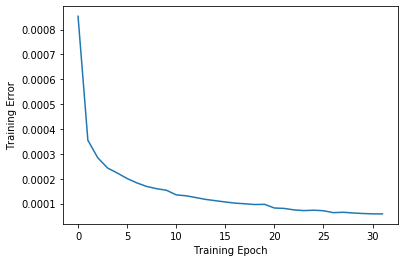

In [43]:
plt.xlabel('Training Epoch')
plt.ylabel('Training Error')
plt.plot(errors)

Of course, the training error do not give us the full picture as the network can overfit the training data. So, we need to use a separate dataset (test set) to calculate test error for validation.

As shown below, the test error is also converging as the training progresses, indicating that the network is generalizing well. However, as we can see, the network is overfitting the training data towards the end of the training. This is indicated by increasing test error but decreasing training error.

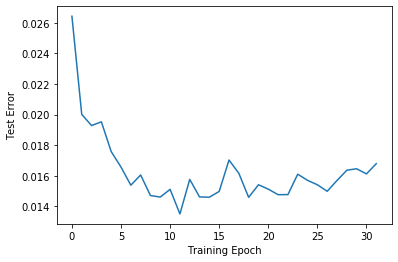

In [48]:
plt.xlabel('Training Epoch')
plt.ylabel('Test Error')
plt.plot(test_errors)

Instead of keeping the final network parameters, we actually want the network parameters that gave the minimum test error. This could happen in any training epoch, which we can find as follows:

In [49]:
epoch_desired = np.argmin(test_errors)
network.reset_layers(epoch_desired)

test_error = network.test(x_test, t_test)

accuracy = 100 - test_error * 100
print(f'Network Accuracy: {accuracy}%')

Network Accuracy: 98.64912021810152%


Not bad for simple feed forward networ. Since the inputs are images, we can probably do better with a convolutional neural network.

To see this in action, let's view the first 16 test images and see how well our network classified them.

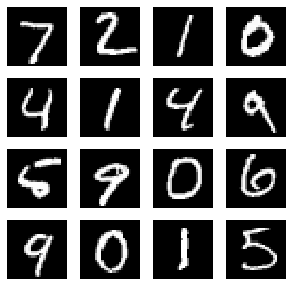

In [50]:
fig = plt.figure(figsize=(5, 5))
for i in range(16):
    sub = fig.add_subplot(4, 4, i + 1)
    sub.axis('off')
    sub.imshow(np.reshape(x_test[i], (28, 28)), cmap='gray')

In [51]:
np.reshape(network.predict(x_test[:16])[1:], (4, 4))

array([[7, 2, 1, 0],
       [4, 1, 4, 9],
       [6, 9, 0, 6],
       [9, 0, 1, 5]])

I believe the network did a pretty good job.

## Testing with Madison dataset

Let's test our network with a separate dataset. This dataset contains two classes *Rainfed* and *Irrigated*, which we will classify as *0* and *1* respectively.

Start by importing the datasets and preprocessing them. Note that, we are normalizing the numeric values in the datasets using mean and standard deviation.

We are also shuffling the whole data.

In [35]:
rainfed = pd.read_csv('Madison_Rainfed.csv').dropna()
irrigated = pd.read_csv('Madison_Irrigated.csv').dropna()

targets = np.array([*([0] * len(rainfed)), *([1] * len(irrigated))])
madison = pd.concat([rainfed, irrigated])

madison = (madison - madison.mean()) / madison.std()
madison = madison.values

indices = np.arange(len(madison))
np.random.shuffle(indices)
madison = madison[indices]
targets = targets[indices]

We again need to divide the dataset into training and test sets for training and validation respectively. Use 75% of dataset as training data and remaining 25% as test dataset.

In [36]:
num_data = len(madison)
train_size = int(0.75 * num_data)
train_x, test_x = madison[:train_size], madison[train_size:]
train_y, test_y = targets[:train_size], targets[train_size:]

Now, create similar neural network as with MNIST, but this time use **ReLu** as the activation function. Then, train it with out dataset.

In [37]:
network = TwoLayerNeuralNetwork(
    num_inputs=24,
    num_hidden=16,
    num_output=2,
    learning_rate=0.001,
    hidden_activation=ReLu
)

network.init_params()

errors, test_errors = network.train(train_x, train_y, 256, 64, [test_x, test_y])

Let's plot the training error, which converges to near zero value quite easily.

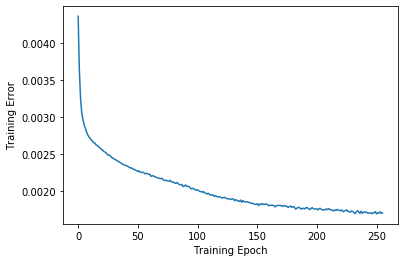

In [38]:
plt.xlabel('Training Epoch')
plt.ylabel('Training Error')
plt.plot(errors)

Let's also plot the test error. Interestingly, not only the error remains above 15% (which is quite high), the test error starts to increase after about 55 epochs. This indicates that the network is overfitting the training error after this point, which is not what we want.

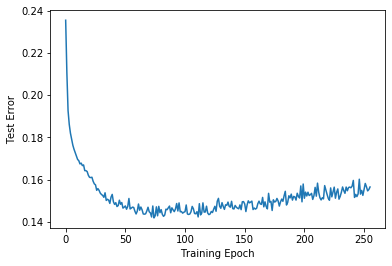

In [39]:
plt.xlabel('Training Epoch')
plt.ylabel('Test Error')
plt.plot(test_errors)

So, let's reset the network to the point where the layer had minimum test error and use that error for calculating our accuracy.

In [40]:
epoch_desired = np.argmin(test_errors)
network.reset_layers(epoch_desired)

test_error = network.test(test_x, test_y)

accuracy = 100 - test_error * 100
print(f'Accuracy: {accuracy}%')


Accuracy: 85.81907444682811%
